In [58]:
from __future__ import division, print_function, absolute_import
import csv
import pandas
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
import os
import xml.etree.ElementTree as etree
import cobra
import numpy as np
from itertools import chain
from cobra.util import solver as sutil
from cobra.core.solution import get_solution
from optlang.symbolics import add, Zero
import pandas as pd
import os
from os.path import join
import matplotlib.pyplot as plt
from cobra.medium import minimal_medium
# Press ⌃R to execute it or replace it with your code.
# Press Double ⇧ to search everywhere for classes, files, tool windows, actions, and settings.
from cobra.flux_analysis import production_envelope
from cobra import Model, Reaction, Metabolite
from cobra.flux_analysis import flux_variability_analysis
import matplotlib.pyplot as plt
from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model



In [59]:
## Pareto function
# Pareto
objective1={''}
objective2={''}
pareto_range = (0.0, 1.001)  # for some reason you need to pick a number higher than 1).
pareto_step_size = 0.01
analysis_type = 'pareto'
metric = 'manhattan'
rxn2avoid = {''}
solver='gurobi'
constants = {'deltaC_CO2': 0.0055, 'D_H2O_0': 2.13E-05, 'D_CO2_0': 1.33E-05, 'mid_day': 6, 'deltaT': 2,
             'FeasTol': 1e-03, 'OptTol': 1e-03}
def pareto_analysis(model, objective1=objective1, objective2=objective2, pareto_range=pareto_range, metric=metric):
    reaction_obj1 = model.reactions.get_by_id(objective1)
    reaction_obj2 = model.reactions.get_by_id(objective2)
    result_list = []
    model.objective = {}
    reaction_obj1.objective_coefficient = 1
    solution = model.optimize()
    print("\nSolving model (FBA) for determining objective 1 flux...")
    max_obj1 = dict(solution.fluxes)[objective1]
    print("Max {0}: {1}".format(objective1, max_obj1))
    # change objective
    reaction_obj1.objective_coefficient = 0
    reaction_obj2.objective_coefficient = 1
    print("\nSolving all iterations for Pareto frontier (FBA)...")
    for pareto in np.arange(pareto_range[0], pareto_range[1], pareto_step_size):
        if pareto == 1:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.999 # we need to add a bit of slack as the quadratic optimization is less accurate than the linear couterpart
        else:
            reaction_obj1.lower_bound = max_obj1 * pareto  # * 0.9999
        sol = model.optimize(objective_sense='maximize')
        # fix this minimal water loss value
        reaction_obj2.bounds = (sol.get_primal_by_id(objective2), sol.get_primal_by_id(objective2))
        if metric == 'manhattan':
            solution = cobra.flux_analysis.pfba(model)
            # print({'proline sink': solution['SK_PRO_c_06'], 'biomass 05': solution['Leaf_biomass_tx_05'], 'biomass 06': solution['Leaf_biomass_tx_06']})
            # solution.fluxes.to_excel(f'pareto_no_{pareto}.xlsx')
            result_list.append([pareto, solution[objective1], solution[objective2]])
            reaction_obj2.bounds = (0, 1000.0)
        elif metric == 'euclidean':

            # make copy because that is easier that reverting all the solver settings
            copy_model = model.copy()
            model.solver = solver

            FeasTol = float(constants['FeasTol'])
            OptTol = float(constants['OptTol'])

            copy_model.solver.configuration.tolerances.feasibility = FeasTol
            copy_model.solver.configuration.tolerances.optimality = OptTol

            rxnlist = [r for r in copy_model.reactions if r.id not in rxn2avoid]

            obj_vars = chain.from_iterable([r.flux_expression ** 2] for r in rxnlist)
            copy_model.objective = copy_model.problem.Objective(add(obj_vars), direction='min')

            print('\nSolving quadratic minimisation of sum of fluxes')
            #print(solver)
            solution = copy_model.optimize(objective_sense=None)
            result_list.append([pareto, solution[objective1], solution[objective2]])
        reaction_obj2.bounds = (0, 1000.0)
    return result_list

In [60]:
model_rs = read_sbml_model('beta_day_RS_DM.xml')


In [61]:
core_model=model_rs
#core_model.metabolites.query('OXIDIZED')
core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_m')

Metabolite identifier,OXIDIZED_GLUTATHIONE_m
Name,OXIDIZED-GLUTATHIONE
Memory address,0x18141eba0
Formula,C20H30N6O12S2
Compartment,m
In 8 reaction(s),"RS_Plant_GPX1_4_M, RS_Plant_44_M, GLUTATHIONE_REDUCT_NADPH_RXN_m, RS_Plant_GPX1_3_M, 1_PERIOD_8_PERIOD_5_PERIOD_1_RXN_m, RS_Plant_GPX1_1_M, RS_Plant_GPX_M3, RS_Plant_GPX1_2_M"


In [62]:
## Initialize demand metabolites for all RS
core_model.add_metabolites([
    Metabolite(
    'GLUTATHIONE_cell',
    name='GLUTATHIONE',
    compartment='cell',
    formula='C10H16N3O6S',
    charge=-1
    ),
    Metabolite('ASCORBATE_cell',
    name='ASCORBATE',
    compartment='cell',
    formula='C6H7O6',
    charge=-1
    ),
    Metabolite('L_DEHYDRO_ASCORBATE_cell',
    name='L_DEHYDRO_ASCORBATE',
    compartment='cell',
    formula='C6H5O6',
    charge=-1
    ),
    Metabolite('OXIDIZED_GLUTATHIONE_cell',
    name='OXIDIZED_GLUTATHIONE',
    compartment='cell',
    formula='C20H30N6O12S2',
    charge=-2
    )
    ])

In [63]:
## Glutathione
reaction = Reaction('Glutathione_p_demand')
reaction.name = 'GLUTATHIONE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_p'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('Glutathione_n_demand')
reaction.name = 'GLUTATHIONE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_n'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('Glutathione_m_demand')
reaction.name = 'GLUTATHIONE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_m'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_x_demand')
reaction.name = 'GLUTATHIONE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_x'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_e_demand')
reaction.name = 'GLUTATHIONE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('GLUTATHIONE_e'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('Glutathione_c_demand')
reaction.name = 'GLUTATHIONE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =-1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('GLUTATHIONE_c'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
#
reaction = Reaction('Glutathione_v_demand')
reaction.name = 'GLUTATHIONE vacuolar demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('GLUTATHIONE_v'): -1.0,core_model.metabolites.get_by_id('GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

GLUTATHIONE_p --> GLUTATHIONE_cell
GLUTATHIONE_n --> GLUTATHIONE_cell
GLUTATHIONE_m --> GLUTATHIONE_cell
GLUTATHIONE_x --> GLUTATHIONE_cell
GLUTATHIONE_e --> GLUTATHIONE_cell
GLUTATHIONE_c <=> GLUTATHIONE_cell
GLUTATHIONE_v --> GLUTATHIONE_cell


In [64]:
## OXIDIZED_GLUTATHIONE
reaction = Reaction('OXIDIZED_GLUTATHIONE_p_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_p'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_n_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_n'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_m_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_m'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_x_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_x'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_e_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('OXIDIZED_GLUTATHIONE_e'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('OXIDIZED_GLUTATHIONE_c_demand')
reaction.name = 'OXIDIZED_GLUTATHIONE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =-1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('OXIDIZED_GLUTATHIONE_c'): -1.0,core_model.metabolites.get_by_id('OXIDIZED_GLUTATHIONE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])


OXIDIZED_GLUTATHIONE_p --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_n --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_m --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_x --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_e --> OXIDIZED_GLUTATHIONE_cell
OXIDIZED_GLUTATHIONE_c <=> OXIDIZED_GLUTATHIONE_cell


In [65]:
## ASCORBATE
reaction = Reaction('ASCORBATE_p_demand')
reaction.name = 'ASCORBATE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_p'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('ASCORBATE_n_demand')
reaction.name = 'ASCORBATE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_n'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('ASCORBATE_m_demand')
reaction.name = 'ASCORBATE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_m'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_x_demand')
reaction.name = 'ASCORBATE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_x'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_e_demand')
reaction.name = 'ASCORBATE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('ASCORBATE_e'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_c_demand')
reaction.name = 'ASCORBATE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =-1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('ASCORBATE_c'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_v_demand')
reaction.name = 'ASCORBATE vacuolar demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_v'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('ASCORBATE_g_demand')
reaction.name = 'ASCORBATE glyoxysome demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('ASCORBATE_g'): -1.0,core_model.metabolites.get_by_id('ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

ASCORBATE_p --> ASCORBATE_cell
ASCORBATE_n --> ASCORBATE_cell
ASCORBATE_m --> ASCORBATE_cell
ASCORBATE_x --> ASCORBATE_cell
ASCORBATE_e --> ASCORBATE_cell
ASCORBATE_c <=> ASCORBATE_cell
ASCORBATE_v --> ASCORBATE_cell
ASCORBATE_g --> ASCORBATE_cell


In [66]:
## L_DEHYDRO_ASCORBATE
reaction = Reaction('L_DEHYDRO_ASCORBATE_p_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE plastid demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_p'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_n_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE nucleus demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_n'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
core_model.add_reactions([reaction])
print(reaction.reaction) 
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_m_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE mitochondrial demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_m'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_x_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE peroxisomal demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_x'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_e_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE extracellular demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('L_DEHYDRO_ASCORBATE_e'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_c_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE cytosolic transport'
reaction.subsystem = 'RS demand'
reaction.lower_bound =-1000.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id ('L_DEHYDRO_ASCORBATE_c'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])
##
reaction = Reaction('L_DEHYDRO_ASCORBATE_g_demand')
reaction.name = 'L_DEHYDRO_ASCORBATE glyoxysome demand'
reaction.subsystem = 'RS demand'
reaction.lower_bound =0.  # This is the default
reaction.upper_bound = 1000.  # This is the default
reaction.add_metabolites({core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_g'): -1.0,core_model.metabolites.get_by_id('L_DEHYDRO_ASCORBATE_cell'): 1.0})
print(reaction.reaction) 
core_model.add_reactions([reaction])

L_DEHYDRO_ASCORBATE_p --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_n --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_m --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_x --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_e --> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_c <=> L_DEHYDRO_ASCORBATE_cell
L_DEHYDRO_ASCORBATE_g --> L_DEHYDRO_ASCORBATE_cell


In [67]:
##Constraints
rubisco = core_model.problem.Constraint(3 * core_model.reactions.get_by_id("RXN_961_p").flux_expression - core_model.reactions.get_by_id("RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p").flux_expression,lb=0, ub=0,)
core_model.add_cons_vars([rubisco])
## 
atp = core_model.problem.Constraint((0.0049*core_model.reactions.get_by_id("Photon_tx").flux_expression+2.7851)-core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp)
##
atp_nadph_03 = core_model.problem.Constraint(3 * (core_model.reactions.get_by_id("NADPHoxm_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxc_tx").flux_expression + core_model.reactions.get_by_id("NADPHoxp_tx").flux_expression) - core_model.reactions.get_by_id("ATPase_tx").flux_expression, lb=0, ub=0)
core_model.add_cons_vars(atp_nadph_03)

In [68]:
core_model.add_boundary(core_model.metabolites.get_by_id("L_DEHYDRO_ASCORBATE_cell"), type="demand")
core_model.reactions.get_by_id('DM_L_DEHYDRO_ASCORBATE_cell').bounds=(0,0.0041)

In [69]:
core_model.add_boundary(core_model.metabolites.get_by_id("ASCORBATE_cell"), type="demand")
core_model.reactions.get_by_id('DM_ASCORBATE_cell').bounds=(0,0.0088)

In [70]:
core_model.add_boundary(core_model.metabolites.get_by_id("GLUTATHIONE_cell"), type="demand")
core_model.reactions.get_by_id('DM_GLUTATHIONE_cell').bounds=(0,0.003)

In [71]:
core_model.add_boundary(core_model.metabolites.get_by_id("OXIDIZED_GLUTATHIONE_cell"), type="demand")
core_model.reactions.get_by_id('DM_OXIDIZED_GLUTATHIONE_cell').bounds=(0,0.00083)

In [72]:
#core_model.add_boundary(core_model.metabolites.get_by_id("HYDROGEN_PEROXIDE_e"), type="exchange")
#core_model.reactions.get_by_id('H2O2_e_demand').bounds=(0,0.04)
#core_model.reactions.get_by_id('DM_HYDROGEN_PEROXIDE_cell').bounds=(0,3.58)
##
#h2o2_biotic = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=42.11)
#core_model.add_cons_vars(h2o2_biotic)
##
h2o2_drought = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=0.000459864261)
core_model.add_cons_vars(h2o2_drought)
##
#core_model.reactions.get_by_id('DM_SUPER_OXIDE_cell').bounds=(0,0.28)
##
#h2o2_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=3.1939167)
#core_model.add_cons_vars(h2o2_uvb)
##
#h2o2_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("ASCORBATE_p_demand").flux_expression + core_model.reactions.get_by_id("ASCORBATE_m_demand").flux_expression + core_model.reactions.get_by_id("ASCORBATE_x_demand").flux_expression + core_model.reactions.get_by_id("ASCORBATE_e_demand").flux_expression, lb=0, ub=0.008459760077)
#core_model.add_cons_vars(h2o2_uvb)
##
#o2s_uvb = core_model.problem.Constraint(core_model.reactions.get_by_id("Super_oxide_p_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_m_demand").flux_expression + core_model.reactions.get_by_id("Super_oxide_x_demand").flux_expression, lb=0, ub=3.581972053)
#core_model.add_cons_vars(o2s_uvb)
##
#h2o2_ell = core_model.problem.Constraint(core_model.reactions.get_by_id("H2O2_p_demand").flux_expression + core_model.reactions.get_by_id("H2O2_m_demand").flux_expression + core_model.reactions.get_by_id("H2O2_x_demand").flux_expression + core_model.reactions.get_by_id("H2O2_e_demand").flux_expression, lb=0, ub=3.58)
#core_model.add_cons_vars(h2o2_ell)
##
#h2o2_demand = core_model.problem.Constraint(core_model.reactions.get_by_id("DM_NITRIC-OXIDE_cell").flux_expression, lb=0, ub=0.0001802061558)
#core_model.add_cons_vars(h2o2_demand)


In [73]:
cat_cp_demand = core_model.problem.Constraint(core_model.reactions.get_by_id("SUPEROX_DISMUT_RXN_p").flux_expression, lb=0, ub=0.381939167)
#core_model.add_cons_vars(cat_cp_demand)
##
cat_c_demand = core_model.problem.Constraint(core_model.reactions.get_by_id("RS_Plant_SOD_X").flux_expression, lb=0, ub=0.381939167)
#core_model.add_cons_vars(cat_c_demand)
## catalase
#core_model.reactions.get_by_id('RS_Plant_3_CP').bounds=(0,5)
#core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_c').bounds=(0,2.5)
# peroxidase
#core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_p').bounds=(0,3.8)
#core_model.reactions.get_by_id('GLUTATHIONE_PEROXIDASE_RXN_p').bounds=(0,3.8)
#core_model.reactions.get_by_id('Mehler_Reaction_p').bounds=(0,3.8)

In [74]:
# catalase
#core_model.reactions.get_by_id('CATAL_RXN_x').bounds=(1,1000)
#core_model.reactions.get_by_id('RS_Plant_CAT_M').bounds=(1,1000)
# peroxidase
#core_model.reactions.get_by_id('GLUTATHIONE_REDUCT_NADPH_RXN_m').bounds=(6.8,1000)
#core_model.reactions.get_by_id('GLUTATHIONE_REDUCT_NADPH_RXN_p').bounds=(6.8,1000)


Solving model (FBA) for determining objective 1 flux...
Max DM_HYDROGEN_PEROXIDE_cell: 73.58186326546381

Solving all iterations for Pareto frontier (FBA)...
        0          1         2
0    0.00   0.000000  0.215272
1    0.01   0.735819  0.213754
2    0.02   1.471637  0.212236
3    0.03   2.207456  0.210717
4    0.04   2.943275  0.209199
..    ...        ...       ...
96   0.96  70.638589  0.009388
97   0.97  71.374407  0.007041
98   0.98  72.110226  0.004694
99   0.99  72.846045  0.002347
100  1.00  73.581863  0.000000

[101 rows x 3 columns]


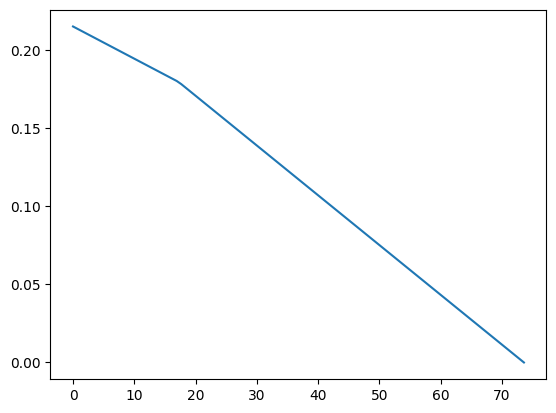

In [75]:
## plot pareto plot
objective1 =  'DM_HYDROGEN_PEROXIDE_cell'
objective2 =  'AraCore_Biomass_tx'
solution_primary=pareto_analysis(core_model, objective1 = objective1, objective2=objective2, pareto_range = pareto_range, metric = metric)
#pd.DataFrame(result_list).to_excel('results.xlsx')
data=pd.DataFrame(solution_primary)
print(data)
plt.plot(data[1],data[2]) 
#plt.ylim([0.2152,0.2153])
#plt.xlim([0,0.03])
plt.show()##
#objs_rs=[AraCore_Biomass_tx 'Phloem_output_tx','DM_NITRIC-OXIDE_cell','DM_HS_cell','DM_SUPER_OXIDE_cell','DM_HC00250_cell','DM_CPD0-1395_cell','DM_SO3_cell','DM_CPD-12377_cell','DM_HYDROGEN_PEROXIDE_cell','DM_ho2_rad_cell']

In [76]:
# catalase
core_model.reactions.get_by_id('CATAL_RXN_x').bounds=(15,1000)
core_model.reactions.get_by_id('RS_Plant_CAT_M').bounds=(5,1000)
# peroxidase
core_model.reactions.get_by_id('GLUTATHIONE_REDUCT_NADPH_RXN_m').bounds=(6.8,1000)
core_model.reactions.get_by_id('GLUTATHIONE_REDUCT_NADPH_RXN_p').bounds=(6.8,1000)
# superoxide dismutase
core_model.reactions.get_by_id('RS_Plant_SOD_X').bounds=(0,73)
core_model.reactions.get_by_id('RS_Plant_SOD_M').bounds=(0,73)
core_model.reactions.get_by_id('RS_Plant_SOD_V').bounds=(0,73)
core_model.reactions.get_by_id('SUPEROX_DISMUT_RXN_p').bounds=(0,73)
# ascorbate peroxidase
core_model.reactions.get_by_id('RS_Plant_MDHAR_C').bounds=(0,0.4)
core_model.reactions.get_by_id('L_ASCORBATE_PEROXIDASE_RXN_p').bounds=(0,0.4)
# peroxidase
core_model.reactions.get_by_id('RS_Plant_PER1_C').bounds=(0,0.22)
core_model.reactions.get_by_id('RS_Plant_PER1_CP').bounds=(0,0.22)